<a href="https://colab.research.google.com/github/ML-Challenge/week5-preprocessing-and-tunning/blob/master/L2.Hyperparameter%20Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" /></a>

Building powerful machine learning models depends heavily on the set of hyperparameters used. But with increasingly complex models with lots of options, how do we efficiently find the best settings for our particular problem? In this lesson we will get practical experience in using some common methodologies for automated hyperparameter tuning in Python using Scikit Learn. These include Grid Search, Random Search & advanced optimization methodologies including Bayesian & Genetic algorithms. We will use a dataset predicting credit card defaults as we build skills to dramatically increase the efficiency and effectiveness of our machine learning model building.

# Setup

In [1]:
# Download lesson datasets
# Required if you're using Google Colab
#!wget "https://github.com/ML-Challenge/week5-preprocessing-and-tunning/raw/master/datasets.zip"
#!unzip -o datasets.zip

In [2]:
# Import utils
# We'll be using this module throughout the lesson
import utils

In [3]:
# Import dependencies
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
# and setting the size of all plots.
plt.rcParams['figure.figsize'] = [20, 10]

from sklearn.model_selection import train_test_split

# Hyperparameters and Parameters

In this introductory chapter we will learn the difference between hyperparameters and parameters. We will practice extracting and analyzing parameters, setting hyperparameter values for several popular machine learning algorithms. Along the way we will learn some best practice tips & tricks for choosing which hyperparameters to tune and what values to set & build learning curves to analyze your hyperparameter choices.

## Introduction & 'Parameters'

### Parameters in Logistic Regression

Now that we have had a chance to explore what a parameter is, let us apply this knowledge. It is important to be able to review any new algorithm and identify which elements are parameters and hyperparameters.

Which of the following is a parameter for the Scikit Learn logistic regression model?

**Possible Answers**

1. `n_jobs`
2. `coef_`
3. `class_weight`
4. `LogisticRegression()`

In [4]:
# Pass 1,2,3 or 4 as argument
utils.which_is_param()

Enter 1, 2, 3 or 4 as the answer


### Extracting a Logistic Regression parameter

We are now going to practice extracting an important parameter of the logistic regression model. The logistic regression has a few other parameters you will not explore here but you can review them in the **scikit-learn.org** documentation for the `LogisticRegression()` module under 'Attributes'.

This parameter is important for understanding the direction and magnitude of the effect the variables have on the target.

In this example we will extract the coefficient parameter (found in the `coef_` attribute), zip it up with the original column names, and see which variables had the largest positive effect on the target variable.

In [5]:
utils.credit_card.head()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,SEX_2,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,24,2,2,-1,-1,-2,-2,3913,3102,...,1,0,1,0,0,0,0,1,0,0
2,120000,26,-1,2,0,0,0,2,2682,1725,...,1,0,1,0,0,0,0,0,1,0
3,90000,34,0,0,0,0,0,0,29239,14027,...,1,0,1,0,0,0,0,0,1,0
4,50000,37,0,0,0,0,0,0,46990,48233,...,1,0,1,0,0,0,0,1,0,0
5,50000,57,-1,0,-1,0,0,0,8617,5670,...,0,0,1,0,0,0,0,1,0,0


In [6]:
X = utils.credit_card.drop('default payment next month', axis=1)
y = utils.credit_card['default payment next month']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [8]:
X_train.var()

LIMIT_BAL      1.683949e+10
AGE            8.436027e+01
PAY_0          1.262163e+00
PAY_2          1.439627e+00
PAY_3          1.426575e+00
PAY_4          1.349935e+00
PAY_5          1.263298e+00
PAY_6          1.312433e+00
BILL_AMT1      5.421963e+09
BILL_AMT2      5.064130e+09
BILL_AMT3      4.723364e+09
BILL_AMT4      4.151106e+09
BILL_AMT5      3.722083e+09
BILL_AMT6      3.546589e+09
PAY_AMT1       2.697796e+08
PAY_AMT2       4.285847e+08
PAY_AMT3       3.245948e+08
PAY_AMT4       2.389826e+08
PAY_AMT5       2.297050e+08
PAY_AMT6       3.115320e+08
SEX_2          2.392844e-01
EDUCATION_1    2.279232e-01
EDUCATION_2    2.490030e-01
EDUCATION_3    1.369825e-01
EDUCATION_4    4.173115e-03
EDUCATION_5    9.947138e-03
EDUCATION_6    1.758884e-03
MARRIAGE_1     2.478606e-01
MARRIAGE_2     2.488752e-01
MARRIAGE_3     1.064659e-02
dtype: float64

In [9]:
from sklearn.linear_model import LogisticRegression

log_reg_clf = LogisticRegression(solver='liblinear', random_state=42)

In [10]:
log_reg_clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [11]:
# Create a list of original variable names from the training DataFrame
original_variables = X_train.columns

In [12]:
# Extract the coefficients of the logistic regression estimator
model_coefficients = log_reg_clf.coef_[0]

In [13]:
# Create a dataframe of the variables and coefficients & print it out
coefficient_df = pd.DataFrame({"Variable" : original_variables, "Coefficient": model_coefficients})
coefficient_df

,Variable,Coefficient
0,LIMIT_BAL,-0.000004
1,AGE,-0.011436
2,PAY_0,0.001410
3,PAY_2,0.001108
4,PAY_3,0.000963
5,PAY_4,0.000910
6,PAY_5,0.000821
7,PAY_6,0.000780
8,BILL_AMT1,-0.000008
9,BILL_AMT2,0.000003


In [14]:
# Print out the top 3 positive variables
top_three_df = coefficient_df.sort_values(by="Coefficient", axis=0, ascending=False)[0:3]
top_three_df

,Variable,Coefficient
2,PAY_0,0.001410
3,PAY_2,0.001108
4,PAY_3,0.000963


Nice! We have succesfully extracted and reviewed a very important parameter for the Logistic Regression Model. The coefficients of the model allow you to see which variables are having a larger or smaller impact on the outcome. Additionally the sign lets you know if it is a positive or negative relationship.

### Extracting a Random Forest parameter

We will now translate the work previously undertaken on the logistic regression model to a random forest model. A parameter of this model is, for a given tree, how it decided to split at each level.

This analysis is not as useful as the coefficients of logistic regression as we will be unlikely to ever explore every split and every tree in a random forest model. However, it is a very useful exercise to peak under the hood at what the model is doing.

In this example we will extract a single tree from our random forest model, visualize it and programmatically extract one of the splits.

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(max_depth=4, random_state=42)

In [16]:
rf_clf.fit(X_train, y_train)

/Users/ca68vj/miniconda3/envs/machine-learning/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [17]:
# Extract the 7th (index 6) tree from the random forest
chosen_tree = rf_clf.estimators_[6]

In [18]:
# Visualize the graph using Graphviz

#from sklearn.tree import export_graphviz

#export_graphviz(chosen_tree, out_file='assets/tree.dot', 
#                feature_names = original_variables, class_names = True,
#                rounded = True, proportion = False, precision = 2, filled = True)

# Convert to png using system command 
#from subprocess import call
#call(['dot', '-Tpng', 'assets/tree.dot', '-o', 'assets/tree.png', '-Gdpi=600'])

# Display in jupyter notebook
#from IPython.display import Image
#Image(filename = 'assets/tree.png')

[Text(558.0, 489.24, 'PAY_2 <= 1.5\ngini = 0.34\nsamples = 13248\nvalue = [16357, 4643]\nclass = y[0]'),
 Text(279.0, 380.52000000000004, 'PAY_AMT4 <= 1877.5\ngini = 0.28\nsamples = 11329\nvalue = [14985, 2961]\nclass = y[0]'),
 Text(139.5, 271.8, 'PAY_3 <= 1.0\ngini = 0.33\nsamples = 5894\nvalue = [7451, 1931]\nclass = y[0]'),
 Text(69.75, 163.08000000000004, 'PAY_0 <= 1.5\ngini = 0.32\nsamples = 5565\nvalue = [7082, 1765]\nclass = y[0]'),
 Text(34.875, 54.360000000000014, 'gini = 0.29\nsamples = 5312\nvalue = [6965, 1483]\nclass = y[0]'),
 Text(104.625, 54.360000000000014, 'gini = 0.41\nsamples = 253\nvalue = [117, 282]\nclass = y[1]'),
 Text(209.25, 163.08000000000004, 'BILL_AMT2 <= 26573.0\ngini = 0.43\nsamples = 329\nvalue = [369, 166]\nclass = y[0]'),
 Text(174.375, 54.360000000000014, 'gini = 0.45\nsamples = 240\nvalue = [251, 135]\nclass = y[0]'),
 Text(244.125, 54.360000000000014, 'gini = 0.33\nsamples = 89\nvalue = [118, 31]\nclass = y[0]'),
 Text(418.5, 271.8, 'PAY_6 <= 1.0\

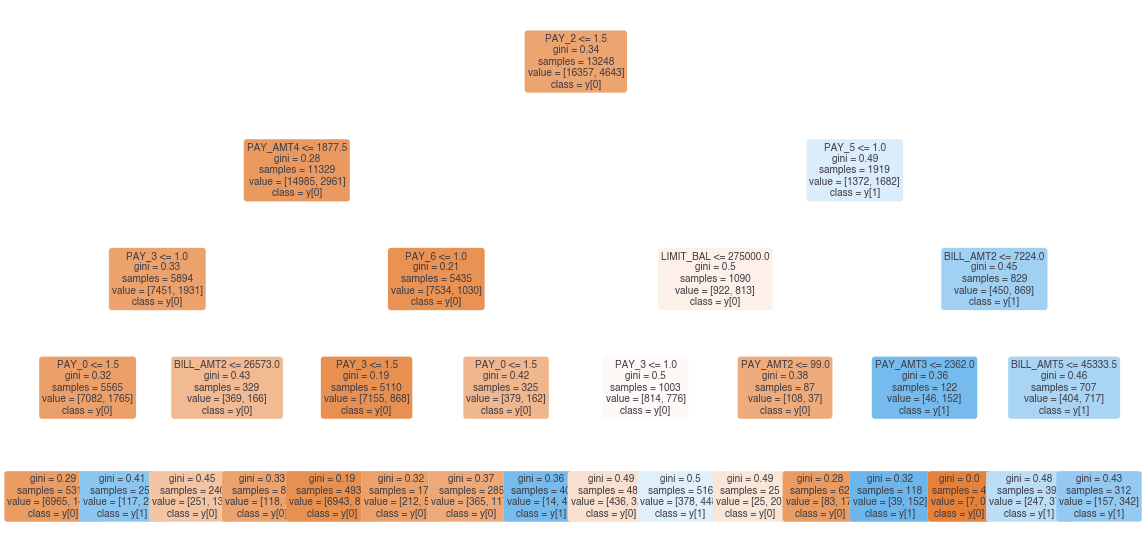

In [19]:
from sklearn.tree import plot_tree

plot_tree(chosen_tree,feature_names = original_variables, class_names = True,
                rounded = True, proportion = False, precision = 2, filled = True, fontsize=10)

## Introducing Hyperparameters

### Hyperparameters in Random Forests

As you saw, there are many different hyperparameters available in a Random Forest model using Scikit Learn. Here you can remind yourself how to differentiate between a hyperparameter and a parameter, and easily check whether something is a hyperparameter.

We can create a random forest estimator from the imported Scikit Learn package. Then print this estimator out to see the hyperparameters and their values.

Which of the following is a hyperparameter for the Scikit Learn random forest model?

In [20]:
rf_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

**Possible Answers**

1. `oob_score`
2. `classes_`
3. `trees`
4. `random_level`

In [21]:
# Pass 1,2,3 or 4 as argument
utils.which_is_hyperparam()

Enter 1, 2, 3 or 4 as the answer


### Exploring Random Forest Hyperparameters

Understanding what hyperparameters are available and the impact of different hyperparameters is a core skill for any data scientist. As models become more complex, there are many different settings we can set, but only some will have a large impact on your model.

We will now assess an existing random forest model (it has some bad choices for hyperparameters!) and then make better choices for a new random forest model and assess its performance.

In [22]:
rf_clf_bad = RandomForestClassifier(n_estimators=5, random_state=42)
rf_clf_bad.fit(X_train, y_train)
rf_bad_predictions = rf_clf_bad.predict(X_test)

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Get confusion matrix & accuracy for the bad rf_model
print(f'Confusion Matrix: \n\n {confusion_matrix(y_test, rf_bad_predictions)} \n Accuracy Score: \n\n {accuracy_score(y_test, rf_bad_predictions)}')

Confusion Matrix: 

 [[6340  669]
 [1260  731]] 
 Accuracy Score: 

 0.7856666666666666


In [24]:
# Create a new random forest classifier with better hyperparamaters
rf_clf_new = RandomForestClassifier(n_estimators=500, random_state=42)

In [25]:
# Fit this to the data and obtain predictions
rf_new_predictions = rf_clf_new.fit(X_train, y_train).predict(X_test)

In [26]:
# Get confusion matrix & accuracy for the new rf_model
print(f'Confusion Matrix: \n\n {confusion_matrix(y_test, rf_new_predictions)} \n Accuracy Score: \n\n {accuracy_score(y_test, rf_new_predictions)}')

Confusion Matrix: 

 [[6601  408]
 [1253  738]] 
 Accuracy Score: 

 0.8154444444444444


Nice! We got a nice 3% accuracy boost just from changing the `n_estimators`. We have had our first taste of hyperparameter tuning for a random forest model.

### Hyperparameters of KNN

To apply the concepts learned in the prior exercise, it is good practice to try out learnings on a new algorithm. The k-nearest-neighbors algorithm is not as popular as it used to be but can still be an excellent choice for data that has groups of data that behave similarly. Could this be the case for our credit card users?

In this case we will try out several different values for one of the core hyperparameters for the knn algorithm and compare performance.

In [27]:
from sklearn.neighbors import KNeighborsClassifier

# Build a knn estimator for each value of n_neighbours
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_10 = KNeighborsClassifier(n_neighbors=10)
knn_20 = KNeighborsClassifier(n_neighbors=20)

In [28]:
# Fit each to the training data & produce predictions
knn_5_predictions = knn_5.fit(X_train, y_train).predict(X_test)
knn_10_predictions = knn_10.fit(X_train, y_train).predict(X_test)
knn_20_predictions = knn_20.fit(X_train, y_train).predict(X_test)

In [29]:
# Get an accuracy score for each of the models
knn_5_accuracy = accuracy_score(y_test, knn_5_predictions)
knn_10_accuracy = accuracy_score(y_test, knn_10_predictions)
knn_20_accuracy = accuracy_score(y_test, knn_20_predictions)

print(f"The accuracy of 5, 10, 20 neighbours was {knn_5_accuracy}, {knn_10_accuracy}, {knn_20_accuracy}")

The accuracy of 5, 10, 20 neighbours was 0.7527777777777778, 0.7741111111111111, 0.7774444444444445


Phew! We succesfully tested 3 different options for 1 hyperparameter, but it was pretty exhausting. Next, we will try to find a way to make this easier.

## Setting & Analyzing Hyperparameter Values

### Automating Hyperparameter Choice

Finding the best hyperparameter of interest without writing hundreds of lines of code for hundreds of models is an important efficiency gain that will greatly assist your future machine learning model building.

An important hyperparameter for the GBM algorithm is the learning rate. But which learning rate is best for this problem? By writing a loop to search through a number of possibilities, collating these and viewing them we can find the best one.

Possible learning rates to try include 0.001, 0.01, 0.05, 0.1, 0.2 and 0.5

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

In [31]:
# Set the learning rates & results storage
learning_rates = [0.001, 0.01, 0.05, 0.1, 0.2, 0.5]
results_list = []

In [32]:
# Create the for loop to evaluate model predictions for each learning rate
for learning_rate in learning_rates:
    model = GradientBoostingClassifier(learning_rate=learning_rate, random_state=42)
    predictions = model.fit(X_train, y_train).predict(X_test)
    # Save the learning rate and accuracy score
    results_list.append([learning_rate, accuracy_score(y_test, predictions)])

In [33]:
# Gather everything into a DataFrame
results_df = pd.DataFrame(results_list, columns=['learning_rate', 'accuracy'])
print(results_df)

   learning_rate  accuracy
0          0.001  0.778778
1          0.010  0.817556
2          0.050  0.817889
3          0.100  0.817000
4          0.200  0.815667
5          0.500  0.811111


Nice! We efficiently tested a few different values for a single hyperparameter and can easily see which learning rate value was the best. Here, it seems that a learning rate of 0.05 yields the best accuracy.

### Building Learning Curves

If we want to test many different values for a single hyperparameter it can be difficult to easily view that in the form of a DataFrame. Previously we learned about a nice trick to analyze this. A graph called a 'learning curve' can nicely demonstrate the effect of increasing or decreasing a particular hyperparameter on the final result.

Instead of testing only a few values for the learning rate, we will test many to easily see the effect of this hyperparameter across a large range of values. A useful function from NumPy is `np.linspace(start, end, num)` which allows us to create a number of values (`num`) evenly spread within an interval (`start`, `end`) that we specify.

In [34]:
# Set the learning rates & accuracies list
learn_rates = np.linspace(0.01, 2, num=30)
accuracies = []

In [35]:
# Create the for loop
for learn_rate in learn_rates:
    # Create the model, predictions & save the accuracies as before
    model = GradientBoostingClassifier(learning_rate=learn_rate, random_state=42)
    predictions = model.fit(X_train, y_train).predict(X_test)
    accuracies.append(accuracy_score(y_test, predictions))

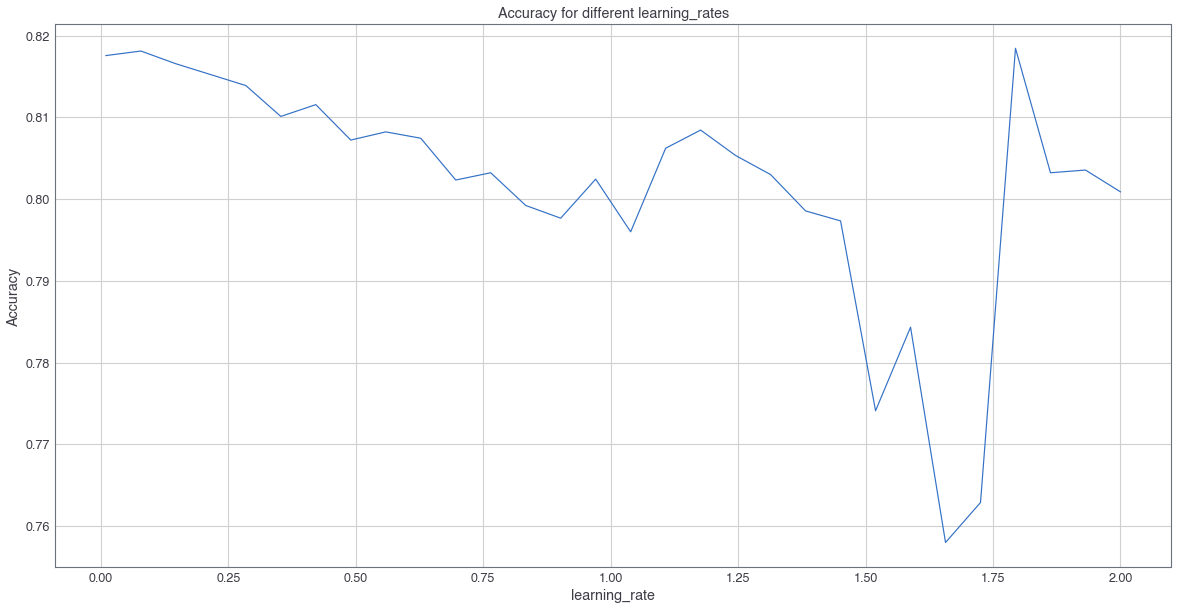

In [36]:
# Plot results    
plt.plot(learn_rates, accuracies)
plt.gca().set(xlabel='learning_rate', ylabel='Accuracy', title='Accuracy for different learning_rates')
plt.show() 

We can see that for low values, you get a pretty good accuracy. However once the learning rate pushes much above 1.5, the accuracy starts to drop. We have learned and practiced a useful skill for visualizing large amounts of results for a single hyperparameter.

# Grid search

This chapter introduces a popular automated hyperparameter tuning methodology called Grid Search. We will learn what it is, how it works and practice undertaking a Grid Search using Scikit Learn. We will then learn how to analyze the output of a Grid Search & gain practical experience doing this.

## Introducing Grid Search

### Build Grid Search functions

In data science it is a great idea to try building algorithms, models and processes 'from scratch' so you can really understand what is happening at a deeper level. Of course there are great packages and libraries for this work (and we will get to that very soon!) but building from scratch will give you a great edge in your data science work.

In this example, we will create a function to take in 2 hyperparameters, build models and return results. We will use this function in a future example.

In [37]:
# Create the function
def gbm_grid_search(learn_rate, max_depth, random_state=42):

    # Create the model
    model = GradientBoostingClassifier(learning_rate=learn_rate, max_depth=max_depth, random_state=random_state)
    
    # Use the model to make predictions
    predictions = model.fit(X_train, y_train).predict(X_test)
    
    # Return the hyperparameters and score
    return([learn_rate, max_depth, accuracy_score(y_test, predictions)])

### Iteratively tune multiple hyperparameters

In this example, we will build on the function you previously created to take in 2 hyperparameters, build a model and return the results. We will now use that to loop through some values and then extend this function and loop with another hyperparameter.

In [38]:
# Create the relevant lists
results_list = []
learn_rate_list = [0.01, 0.1, 0.5]
max_depth_list = [2,4,6]

In [39]:
# Create the for loop
for learn_rate in learn_rate_list:
    for max_depth in max_depth_list:
        results_list.append(gbm_grid_search(learn_rate,max_depth))

In [40]:
# Print the results
results_list

[[0.01, 2, 0.8172222222222222],
 [0.01, 4, 0.8171111111111111],
 [0.01, 6, 0.8157777777777778],
 [0.1, 2, 0.8167777777777778],
 [0.1, 4, 0.8174444444444444],
 [0.1, 6, 0.8154444444444444],
 [0.5, 2, 0.814],
 [0.5, 4, 0.7996666666666666],
 [0.5, 6, 0.7855555555555556]]

In [41]:
# Extend the function input
def gbm_grid_search_extended(learn_rate, max_depth, subsample, random_state=42):

    # Extend the model creation section
    model = GradientBoostingClassifier(learning_rate=learn_rate, max_depth=max_depth, subsample=subsample, random_state=42)
    
    predictions = model.fit(X_train, y_train).predict(X_test)
    
    # Extend the return part
    return([learn_rate, max_depth, subsample, accuracy_score(y_test, predictions)])

In [42]:
results_list = []

# Create the new list to test
subsample_list = [0.4, 0.6]

In [43]:
for learn_rate in learn_rate_list:
    for max_depth in max_depth_list:
        # Extend the for loop
        for subsample in subsample_list:
            # Extend the results to include the new hyperparameter
            results_list.append(gbm_grid_search_extended(learn_rate, max_depth, subsample))

In [44]:
# Print results
results_list

[[0.01, 2, 0.4, 0.8171111111111111],
 [0.01, 2, 0.6, 0.817],
 [0.01, 4, 0.4, 0.8174444444444444],
 [0.01, 4, 0.6, 0.8166666666666667],
 [0.01, 6, 0.4, 0.8154444444444444],
 [0.01, 6, 0.6, 0.8165555555555556],
 [0.1, 2, 0.4, 0.8162222222222222],
 [0.1, 2, 0.6, 0.817],
 [0.1, 4, 0.4, 0.8158888888888889],
 [0.1, 4, 0.6, 0.8147777777777778],
 [0.1, 6, 0.4, 0.8125555555555556],
 [0.1, 6, 0.6, 0.8136666666666666],
 [0.5, 2, 0.4, 0.815],
 [0.5, 2, 0.6, 0.8144444444444444],
 [0.5, 4, 0.4, 0.8022222222222222],
 [0.5, 4, 0.6, 0.7955555555555556],
 [0.5, 6, 0.4, 0.7795555555555556],
 [0.5, 6, 0.6, 0.7773333333333333]]

We have effectively built our own grid search! You went from 2 to 3 hyperparameters and can see how we could extend that to even more values and hyperparameters. That was a lot of effort though. Be warned - we are now entering a world that can get very computationally expensive very fast!

### How Many Models?

Adding more hyperparameters or values, we increase the amount of models created but the increases is not linear it is proportional to how many values and hyperparameters we already have.

How many models would be created when running a grid search over the following hyperparameters and values for a GBM algorithm?

* learning_rate = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1, 2]
* max_depth = [4,6,8,10,12,14,16,18, 20]
* subsample = [0.4, 0.6, 0.7, 0.8, 0.9]
* max_features = ['auto', 'sqrt', 'log2']

**Possible Answers**

1. 26
2. 9 of one model, 9 of another
3. 1 large model
4. 1215

In [45]:
# Enter 1, 2, 3 or 4 as the answer
utils.how_many_models()

Enter 1, 2, 3 or 4 as the answer


## Grid Search with Scikit Learn

### GridSearchCV inputs

Let's test our knowledge of GridSeachCV inputs by answering the question below.

Three GridSearchCV objects are available below. Note that there is no data available to fit these models. Instead, you must answer by looking at their construct.

```
Model #1:
 GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'max_depth': [2, 4, 8, 15], 'max_features': ['auto', 'sqrt']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0) 


Model #2:
 GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'n_neighbors': [5, 10, 20], 'algorithm': ['ball_tree', 'brute']},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring='accuracy', verbose=0) 


Model #3:
 GridSearchCV(cv=7, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'number_attempts': [2, 4, 6], 'max_depth': [3, 6, 9, 12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)
```

Which of these GridSearchCV objects would not work when we try to fit it?

**Possible Answers**

1. `Model #1` would not work when we try to fit it.
2. `Model #2` would not work when we try to fit it.
3. `Model #3` would not work when we try to fit it.
4. None - they will all work when we try to fit them.

In [46]:
# Enter 1, 2, 3 or 4 as the answer
utils.which_grid_search()

Enter 1, 2, 3 or 4 as the answer


### GridSearchCV with Scikit Learn

The `GridSearchCV` module from Scikit Learn provides many useful features to assist with efficiently undertaking a grid search. We will now put it into practice by creating a GridSearchCV object with certain parameters.

The desired options are:

* A Random Forest Estimator, with the split criterion as 'entropy'
* 5-fold cross validation
* The hyperparameters `max_depth` (2, 4, 8, 15) and `max_features` ('auto' vs 'sqrt')
* Use `roc_auc` to score the models
* Use 4 cores for processing in parallel
* Ensure we refit the best model and return training scores

In [47]:
# Create a Random Forest Classifier with specified criterion
rf_class = RandomForestClassifier(criterion='entropy', random_state=42)

In [48]:
# Create the parameter grid
param_grid = {'max_depth': [2, 4, 8, 15], 'max_features': ['auto', 'sqrt']}

In [49]:
# Create a GridSearchCV object
from sklearn.model_selection import GridSearchCV

grid_rf_class=GridSearchCV(
    estimator=rf_class,
    param_grid=param_grid,
    scoring='roc_auc',
    n_jobs=4,
    cv=5,
    refit=True, 
    return_train_score=True)

grid_rf_class

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='entropy',
                                              max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             ii

## Understanding a grid search output

### Exploring the grid search results

We will now explore the `cv_results_` property of the GridSearchCV object defined above. This is a dictionary that we can read into a pandas DataFrame and contains a lot of useful information about the grid search we just undertook.

A reminder of the different column types in this property:

* `time_` columns
* `param_` columns (one for each hyperparameter) and **the** singular `params` column (with all hyperparameter settings)
* a `train_score` column for each cv fold including the `mean_train_score` and `std_train_score` columns
* a `test_score` column for each cv fold including the `mean_test_score` and `std_test_score` columns
* a `rank_test_score` column with a number from 1 to n (number of iterations) ranking the rows based on their `mean_test_score`

In [50]:
# First fit the GridSearchCV
grid_rf_class.fit(X_train, y_train)

/Users/ca68vj/miniconda3/envs/machine-learning/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='entropy',
                                              max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             ii

In [51]:
# Read the cv_results property into a dataframe & print it out
cv_results_df = pd.DataFrame(grid_rf_class.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.098970,0.004155,0.006205,0.000176,2,auto,"{'max_depth': 2, 'max_features': 'auto'}",0.769748,0.768954,0.741041,...,0.756807,0.016606,7,0.759360,0.754980,0.764283,0.763330,0.756669,0.759724,0.003627
1,0.090397,0.001730,0.006135,0.000281,2,sqrt,"{'max_depth': 2, 'max_features': 'sqrt'}",0.769748,0.768954,0.741041,...,0.756807,0.016606,7,0.759360,0.754980,0.764283,0.763330,0.756669,0.759724,0.003627
2,0.142658,0.001720,0.006867,0.000445,4,auto,"{'max_depth': 4, 'max_features': 'auto'}",0.785085,0.784563,0.754313,...,0.770267,0.017420,3,0.773055,0.770862,0.779052,0.779315,0.774455,0.775348,0.003336
3,0.141937,0.002127,0.007104,0.000331,4,sqrt,"{'max_depth': 4, 'max_features': 'sqrt'}",0.785085,0.784563,0.754313,...,0.770267,0.017420,3,0.773055,0.770862,0.779052,0.779315,0.774455,0.775348,0.003336
4,0.244063,0.003054,0.007675,0.000342,8,auto,"{'max_depth': 8, 'max_features': 'auto'}",0.789947,0.786736,0.757696,...,0.775052,0.015329,1,0.818790,0.818052,0.824448,0.825586,0.818812,0.821137,0.003200
5,0.238568,0.003791,0.007796,0.000179,8,sqrt,"{'max_depth': 8, 'max_features': 'sqrt'}",0.789947,0.786736,0.757696,...,0.775052,0.015329,1,0.818790,0.818052,0.824448,0.825586,0.818812,0.821137,0.003200
6,0.414787,0.005095,0.011471,0.001430,15,auto,"{'max_depth': 15, 'max_features': 'auto'}",0.765195,0.771504,0.743326,...,0.757011,0.014430,5,0.959699,0.954309,0.960346,0.964284,0.953961,0.958520,0.003910
7,0.430071,0.008339,0.010796,0.001036,15,sqrt,"{'max_depth': 15, 'max_features': 'sqrt'}",0.765195,0.771504,0.743326,...,0.757011,0.014430,5,0.959699,0.954309,0.960346,0.964284,0.953961,0.958520,0.003910


In [52]:
# Extract and print the column with a dictionary of hyperparameters used
column = cv_results_df.loc[:, ["params"]]
column

,params
0,"{'max_depth': 2, 'max_features': 'auto'}"
1,"{'max_depth': 2, 'max_features': 'sqrt'}"
2,"{'max_depth': 4, 'max_features': 'auto'}"
3,"{'max_depth': 4, 'max_features': 'sqrt'}"
4,"{'max_depth': 8, 'max_features': 'auto'}"
5,"{'max_depth': 8, 'max_features': 'sqrt'}"
6,"{'max_depth': 15, 'max_features': 'auto'}"
7,"{'max_depth': 15, 'max_features': 'sqrt'}"


In [53]:
# Extract and print the row that had the best mean test score
best_row = cv_results_df[cv_results_df["rank_test_score"] == 1]
best_row

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
4,0.244063,0.003054,0.007675,0.000342,8,auto,"{'max_depth': 8, 'max_features': 'auto'}",0.789947,0.786736,0.757696,...,0.775052,0.015329,1,0.81879,0.818052,0.824448,0.825586,0.818812,0.821137,0.0032
5,0.238568,0.003791,0.007796,0.000179,8,sqrt,"{'max_depth': 8, 'max_features': 'sqrt'}",0.789947,0.786736,0.757696,...,0.775052,0.015329,1,0.81879,0.818052,0.824448,0.825586,0.818812,0.821137,0.0032


### Analyzing the best results

At the end of the day, we primarily care about the best performing 'square' in a grid search. Luckily Scikit Learn's `gridSearchCV` objects have a number of parameters that provide key information on just the best square (or row in `cv_results_`).

Three properties you will explore are:

* `best_score_` – The score (here ROC_AUC) from the best-performing square.
* `best_index_` – The index of the row in `cv_results_` containing information on the best-performing square.
* `best_params_` – A dictionary of the parameters that gave the best score, for example `'max_depth': 10`

In [54]:
# Print out the ROC_AUC score from the best-performing square
best_score = grid_rf_class.best_score_
best_score

0.7750521841317459

In [55]:
# Create a variable from the row related to the best-performing square
cv_results_df = pd.DataFrame(grid_rf_class.cv_results_)
best_row = cv_results_df.loc[[grid_rf_class.best_index_]]
best_row

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
4,0.244063,0.003054,0.007675,0.000342,8,auto,"{'max_depth': 8, 'max_features': 'auto'}",0.789947,0.786736,0.757696,...,0.775052,0.015329,1,0.81879,0.818052,0.824448,0.825586,0.818812,0.821137,0.0032


In [56]:
# Get the max_depth parameter from the best-performing square
best_max_depth = grid_rf_class.best_params_["max_depth"]
best_max_depth

8

Nice stuff! Being able to quickly find and prioritize the huge volume of information given back from machine learning modeling output is a great skill. Here we had great practice doing that with `cv_results_` by quickly isolating the key information on the best performing square. This will be very important when our grids grow from 12 squares to many more!

### Using the best results

While it is interesting to analyze the results of our grid search, our final goal is practical in nature; we want to make predictions on our test set using our estimator object.

We can access this object through the `best_estimator_` property of our grid search object.

In this exercise we will take a look inside the `best_estimator_` property and then use this to make predictions on our test set for credit card defaults and generate a variety of scores. Remember that we need to use `predict_proba` rather than `predict` since we need probability values rather than class labels for our roc_auc score. We use a slice `[:,1]` to get probabilities of the positive class.

In [57]:
# See what type of object the best_estimator_ property is
type(grid_rf_class.best_estimator_)

sklearn.ensemble.forest.RandomForestClassifier

In [58]:
# Create an array of predictions directly using the best_estimator_ property
predictions = grid_rf_class.best_estimator_.predict(X_test)

In [59]:
# Take a look to confirm it worked, this should be an array of 1's and 0's
predictions[0:5]

array([0, 0, 0, 1, 0])

In [60]:
# Now create a confusion matrix 
print("Confusion Matrix \n", confusion_matrix(y_test, predictions))

Confusion Matrix 
 [[6660  349]
 [1307  684]]


In [61]:
from sklearn.metrics import roc_auc_score

# Get the ROC-AUC score
predictions_proba = grid_rf_class.best_estimator_.predict_proba(X_test)[:,1]
print("ROC-AUC Score \n", roc_auc_score(y_test, predictions_proba))

ROC-AUC Score 
 0.7704444217841752


Nice stuff! The `.best_estimator_` property is a really powerful property to understand for streamlining our machine learning model building process. We now can run a grid search and seamlessly use the best model from that search to make predictions. Piece of cake!

# Random Search

This chapter introduces another popular automated hyperparameter tuning methodology called Random Search. We will learn what it is, how it works and importantly how it differs from grid search. We will learn some advantages and disadvantages of this method and when to choose this method compared to Grid Search. We will practice undertaking a Random Search with Scikit Learn as well as visualizing & interpreting the output.

## Introducing Random Search

### Randomly Sample Hyperparameters

To undertake a random search, we firstly need to undertake a random sampling of our hyperparameter space.

In this example, we will firstly create some lists of hyperparameters that can be zipped up to a list of lists. Then we will randomly sample hyperparameter combinations preparation for running a random search.

We will use just the hyperparameters `learning_rate` and `min_samples_leaf` of the GBM algorithm to keep the example illustrative and not overly complicated.

In [62]:
# Create a list of values for the learning_rate hyperparameter
learn_rate_list = list(np.linspace(0.01,1.5,200))

In [63]:
# Create a list of values for the min_samples_leaf hyperparameter
min_samples_list = list(range(10,41))

In [64]:
# Combination list
from itertools import product
combinations_list = [list(x) for x in product(learn_rate_list, min_samples_list)]

In [65]:
# Sample hyperparameter combinations for a random search.
random_combinations_index = np.random.choice(range(0, len(combinations_list)), 250, replace=False)
combinations_random_chosen = [combinations_list[x] for x in random_combinations_index]

In [66]:
# Print the result
combinations_random_chosen

[[0.7063316582914573, 15],
 [0.5191457286432161, 28],
 [1.3577386934673366, 16],
 [0.9084924623115578, 32],
 [0.6763819095477387, 33],
 [1.3876884422110551, 40],
 [0.7662311557788944, 35],
 [0.3993467336683417, 15],
 [1.050753768844221, 33],
 [0.34693467336683415, 40],
 [0.14477386934673367, 35],
 [1.0881909547738693, 14],
 [0.8860301507537688, 13],
 [0.5640703517587939, 10],
 [0.20467336683417087, 27],
 [1.305326633165829, 16],
 [1.3951758793969848, 13],
 [1.0432663316582915, 40],
 [1.0058291457286432, 37],
 [0.42180904522613066, 11],
 [0.8411055276381909, 29],
 [0.20467336683417087, 28],
 [1.4251256281407034, 15],
 [0.4442713567839196, 12],
 [1.4700502512562814, 30],
 [0.5865326633165829, 17],
 [1.4625628140703517, 25],
 [1.0657286432160804, 27],
 [1.4775376884422111, 34],
 [0.2720603015075377, 29],
 [0.5341206030150754, 31],
 [0.4891959798994975, 37],
 [0.3394472361809045, 29],
 [0.7812060301507537, 38],
 [1.1705527638190953, 20],
 [1.3951758793969848, 19],
 [1.1705527638190953, 10]

Excellent! We generated some hyperparameter combinations and randomly sampled in that space. The output was not too nice though, in the next example we will use a much more efficient method for this. In a future example we will also make this output look much nicer!

### Randomly Search with Random Forest

To solidify our knowledge of random sampling, let's try a similar exercise but using different hyperparameters and a different algorithm.

As before, we create some lists of hyperparameters that can be zipped up to a list of lists. We will use the hyperparameters `criterion`, `max_depth` and `max_features` of the random forest algorithm. Then we will randomly sample hyperparameter combinations in preparation for running a random search.

We will use a slightly different package for sampling in this task, `random.sample()`.

In [67]:
# Create lists for criterion and max_features
criterion_list = ["gini", "entropy"]
max_feature_list = ["auto", "sqrt", "log2", None]

In [68]:
# Create a list of values for the max_depth hyperparameter
max_depth_list = list(range(3,56))

In [69]:
# Combination list
combinations_list = [list(x) for x in product(criterion_list, max_feature_list, max_depth_list)]

In [70]:
import random

# Sample hyperparameter combinations for a random search
combinations_random_chosen = random.sample(combinations_list, 150)

In [71]:
# Print the result
combinations_random_chosen

[['entropy', None, 9],
 ['gini', None, 41],
 ['entropy', None, 51],
 ['entropy', 'auto', 27],
 ['entropy', None, 42],
 ['entropy', 'auto', 52],
 ['entropy', 'log2', 25],
 ['entropy', None, 33],
 ['gini', 'auto', 35],
 ['gini', None, 33],
 ['gini', 'sqrt', 29],
 ['entropy', None, 11],
 ['gini', 'sqrt', 31],
 ['gini', 'sqrt', 50],
 ['gini', 'sqrt', 49],
 ['gini', None, 12],
 ['gini', 'auto', 23],
 ['gini', 'log2', 51],
 ['gini', None, 43],
 ['entropy', 'auto', 26],
 ['gini', 'auto', 34],
 ['entropy', 'auto', 41],
 ['entropy', 'log2', 4],
 ['entropy', 'log2', 14],
 ['gini', 'sqrt', 9],
 ['entropy', 'auto', 32],
 ['gini', 'log2', 44],
 ['entropy', 'auto', 3],
 ['gini', 'auto', 30],
 ['gini', 'auto', 48],
 ['entropy', None, 48],
 ['gini', None, 20],
 ['gini', None, 40],
 ['gini', 'auto', 7],
 ['entropy', 'auto', 39],
 ['entropy', None, 21],
 ['entropy', None, 8],
 ['entropy', 'sqrt', 17],
 ['entropy', 'log2', 27],
 ['gini', None, 31],
 ['entropy', 'auto', 50],
 ['gini', 'log2', 45],
 ['gini

### Visualizing a Random Search

Visualizing the search space of random search allows us to easily see the coverage of this technique and therefore allows us to see the effect of our sampling on the search space.

In this example we will use several different samples of hyperparameter combinations and produce visualizations of the search space.

In [72]:
def sample_hyperparameters(n_samples):
    global combinations_random_chosen

    if n_samples == len(combinations_list):
        combinations_random_chosen = combinations_list
        return

    combinations_random_chosen = []
    random_combinations_index = np.random.choice(range(0, len(combinations_list)), n_samples, replace=False)
    combinations_random_chosen = [combinations_list[x] for x in random_combinations_index]
    return

In [73]:
def visualize_search():
    rand_y, rand_x = [x[0] for x in combinations_random_chosen], [x[1] for x in combinations_random_chosen]

    # Plot all together
    plt.clf() 
    plt.scatter(rand_y, rand_x, c=['blue']*len(combinations_random_chosen))
    plt.gca().set(xlabel='learn_rate', ylabel='min_samples_leaf', title='Random Search Hyperparameters')
    plt.gca().set_xlim([0.01, 1.5])
    plt.gca().set_ylim([10, 29])
    plt.show()

In [74]:
# Create a list of values for the learning_rate hyperparameter
learn_rate_list = list(np.linspace(0.01,1.5,200))

In [75]:
# Create a list of values for the min_samples_leaf hyperparameter
min_samples_list = list(range(10,41))

In [76]:
# Combination list
combinations_list = [list(x) for x in product(learn_rate_list, min_samples_list)]

In [77]:
# Confirm how hyperparameter combinations & print
number_combs = len(combinations_list)
number_combs

6200

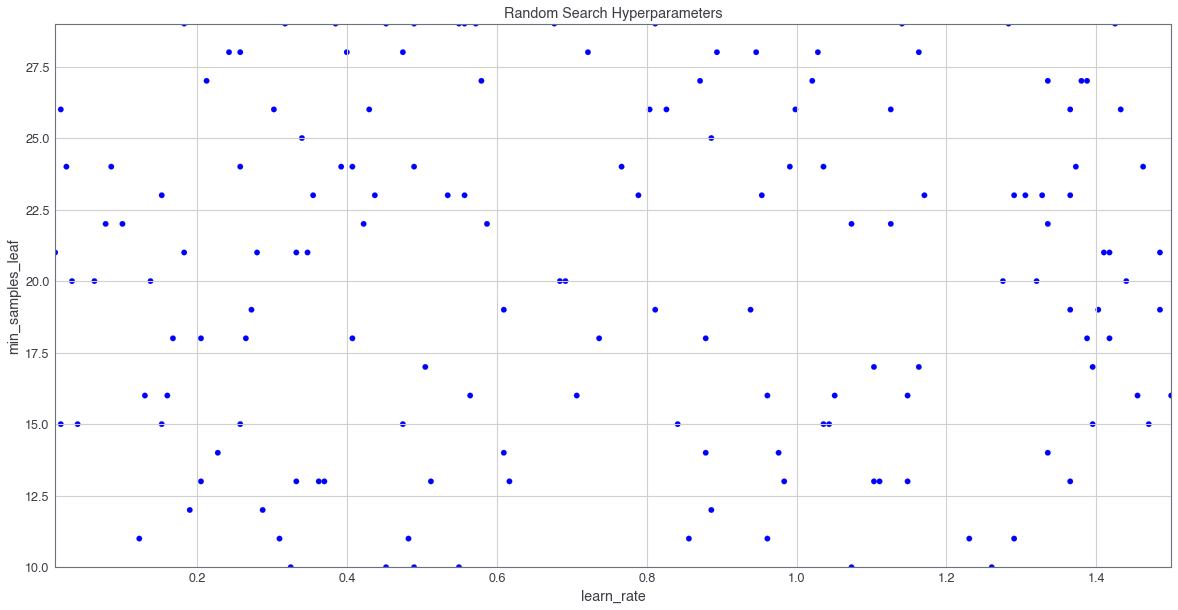

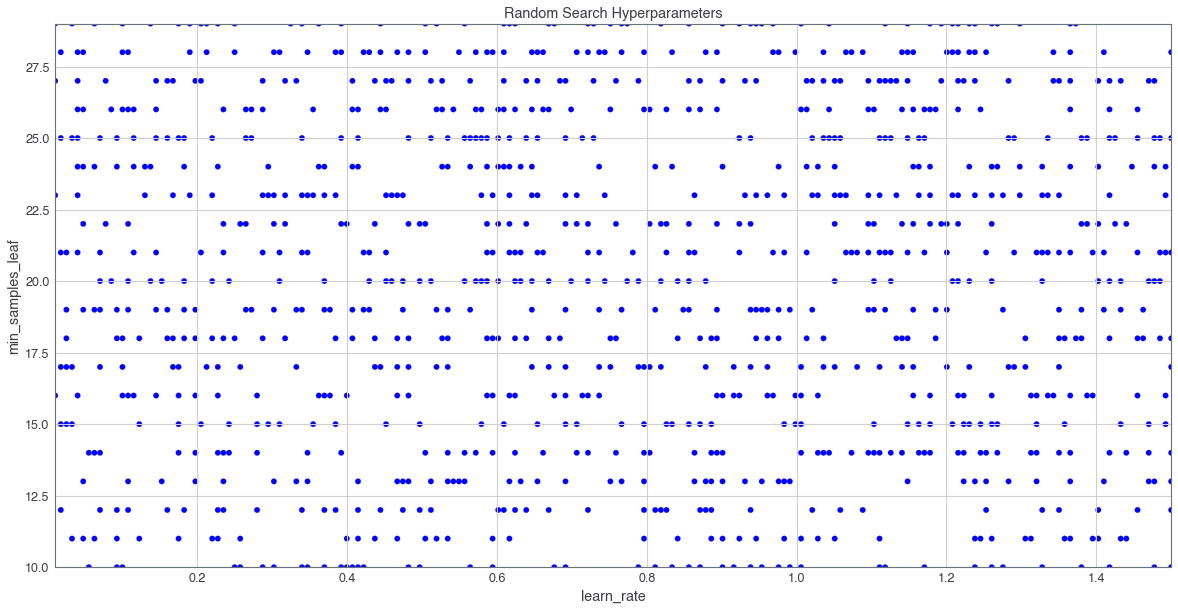

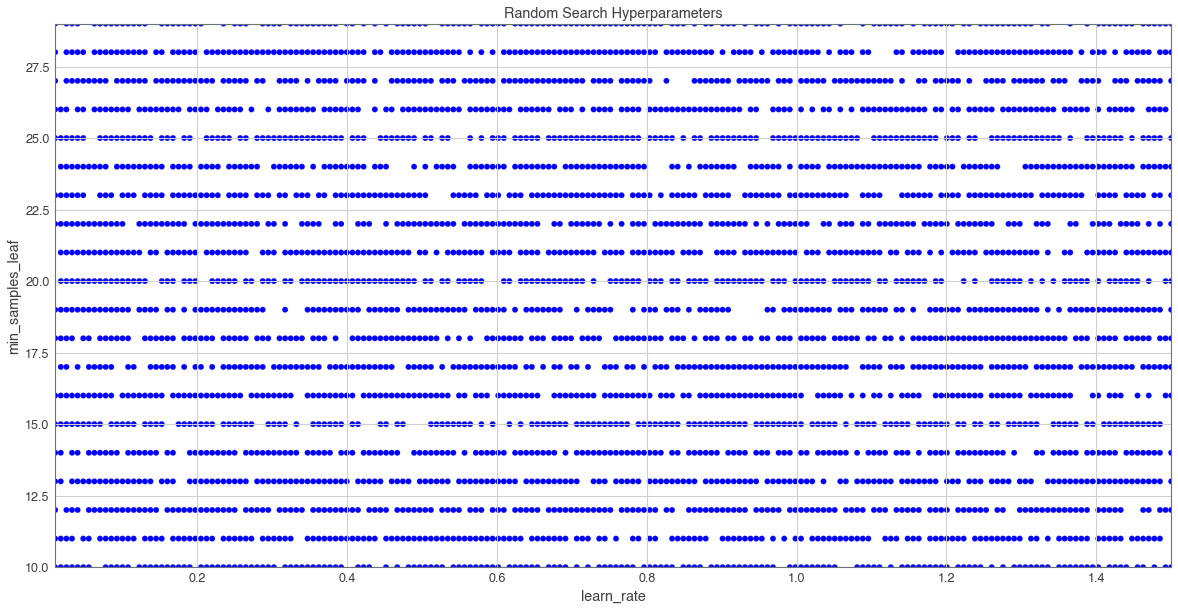

In [78]:
# Sample and visualise combinations
for x in [250, 1500, 5000]:
    sample_hyperparameters(x)
    visualize_search()

Notice how the bigger our sample space of a random search the more it looks like a grid search? In a later example we will look closer at comparing these two methods side by side.

## Random Search in Scikit Learn

### The RandomizedSeachCV Class

Just like the `GridSearchCV` library from Scikit Learn, `RandomizedSearchCV` provides many useful features to assist with efficiently undertaking a random search. We're going to create a `RandomizedSearchCV` object, making the small adjustment needed from the `GridSearchCV` object.

The desired options are:

* A default Gradient Boosting Classifier Estimator
* 5-fold cross validation
* Use accuracy to score the models
* Use 4 cores for processing in parallel
* Ensure you refit the best model and return training scores
* Randomly sample 10 models

The hyperparameter grid should be for `learning_rate` (150 values between 0.1 and 2) and `min_samples_leaf` (all values between 20 and 65).

In [79]:
# Create the parameter grid
param_grid = {'learning_rate': np.linspace(0.1, 2, 150), 'min_samples_leaf': list(range(20, 65))} 

In [80]:
from sklearn.model_selection import RandomizedSearchCV

# Create a random search object
random_GBM_class = RandomizedSearchCV(
    estimator = GradientBoostingClassifier(random_state=42),
    param_distributions = param_grid,
    n_iter = 10,
    scoring='accuracy', n_jobs=4, cv = 5, refit=True, return_train_score = True)

In [81]:
# Fit to the training data
random_GBM_class.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                     

In [82]:
# Print the values used for both hyperparameters
print(random_GBM_class.cv_results_['param_learning_rate'])
print(random_GBM_class.cv_results_['param_min_samples_leaf'])

[0.16375838926174496 1.1201342281879194 0.5718120805369128
 0.8395973154362416 0.9543624161073825 0.30402684563758386
 0.17651006711409395 0.5590604026845637 1.7577181208053692
 0.5208053691275167]
[45 64 55 22 47 29 48 58 57 43]


### RandomSearchCV in Scikit Learn

Let's practice building a RandomizedSearchCV object using Scikit Learn.

The desired options are:

* A RandomForestClassifier Estimator with default 80 estimators
* 3-fold cross validation
* Use AUC to score the models
* Use 4 cores for processing in parallel
* Ensure you refit the best model and return training scores
* Randomly sample 5 models for processing efficiency

The hyperparameter grid should be for `max_depth` (all values between and including 5 and 25) and `max_features` ('auto' and 'sqrt').

In [83]:
# Create the parameter grid
param_grid = {'max_depth': list(range(5,26)), 'max_features': ['auto' , 'sqrt']} 

In [84]:
# Create a random search object
random_rf_class = RandomizedSearchCV(
    estimator = RandomForestClassifier(n_estimators=80, random_state=42),
    param_distributions = param_grid, n_iter = 5,
    scoring='roc_auc', n_jobs=4, cv = 3, refit=True, return_train_score = True)

In [85]:
# Fit to the training data
random_rf_class.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=80,
                                                    n_jobs=None,
  

In [86]:
# Print the values used for both hyperparameters
print(random_rf_class.cv_results_['param_max_depth'])
print(random_rf_class.cv_results_['param_max_features'])

[24 11 6 18 13]
['sqrt' 'auto' 'sqrt' 'auto' 'sqrt']


## Comparing Grid and Random Search

### Grid and Random Search Side by Side

Visualizing the search space of random and grid search together allows us to easily see the coverage that each technique has and therefore brings to life their specific advantages and disadvantages.

In this example, we will sample hyperparameter combinations in a grid search way as well as a random search way, then plot these to see the difference.

In [87]:
# Sample grid coordinates
grid_combinations_chosen = combinations_list[0:300]

In [88]:
# Print result
grid_combinations_chosen

[[0.01, 10],
 [0.01, 11],
 [0.01, 12],
 [0.01, 13],
 [0.01, 14],
 [0.01, 15],
 [0.01, 16],
 [0.01, 17],
 [0.01, 18],
 [0.01, 19],
 [0.01, 20],
 [0.01, 21],
 [0.01, 22],
 [0.01, 23],
 [0.01, 24],
 [0.01, 25],
 [0.01, 26],
 [0.01, 27],
 [0.01, 28],
 [0.01, 29],
 [0.01, 30],
 [0.01, 31],
 [0.01, 32],
 [0.01, 33],
 [0.01, 34],
 [0.01, 35],
 [0.01, 36],
 [0.01, 37],
 [0.01, 38],
 [0.01, 39],
 [0.01, 40],
 [0.017487437185929648, 10],
 [0.017487437185929648, 11],
 [0.017487437185929648, 12],
 [0.017487437185929648, 13],
 [0.017487437185929648, 14],
 [0.017487437185929648, 15],
 [0.017487437185929648, 16],
 [0.017487437185929648, 17],
 [0.017487437185929648, 18],
 [0.017487437185929648, 19],
 [0.017487437185929648, 20],
 [0.017487437185929648, 21],
 [0.017487437185929648, 22],
 [0.017487437185929648, 23],
 [0.017487437185929648, 24],
 [0.017487437185929648, 25],
 [0.017487437185929648, 26],
 [0.017487437185929648, 27],
 [0.017487437185929648, 28],
 [0.017487437185929648, 29],
 [0.0174874371859

In [89]:
# Create a list of sample indexes
sample_indexes = list(range(0,len(combinations_list)))

In [90]:
# Randomly sample 300 indexes
random_indexes = np.random.choice(sample_indexes, 300, replace=False)

In [91]:
# Use indexes to create random sample
random_combinations_chosen = [combinations_list[index] for index in random_indexes]

In [92]:
def visualize_search(grid_combinations_chosen, random_combinations_chosen):
    grid_y, grid_x = [x[0] for x in grid_combinations_chosen], [x[1] for x in grid_combinations_chosen]
    rand_y, rand_x = [x[0] for x in random_combinations_chosen], [x[1] for x in random_combinations_chosen]

    # Plot all together
    plt.scatter(grid_y + rand_y, grid_x + rand_x, c=['red']*300 + ['blue']*300)
    plt.gca().set(xlabel='learn_rate', ylabel='min_samples_leaf', title='Grid and Random Search Hyperparameters')
    plt.gca().set_xlim([0.01, 3.0])
    plt.gca().set_ylim([5, 24])
    plt.show()

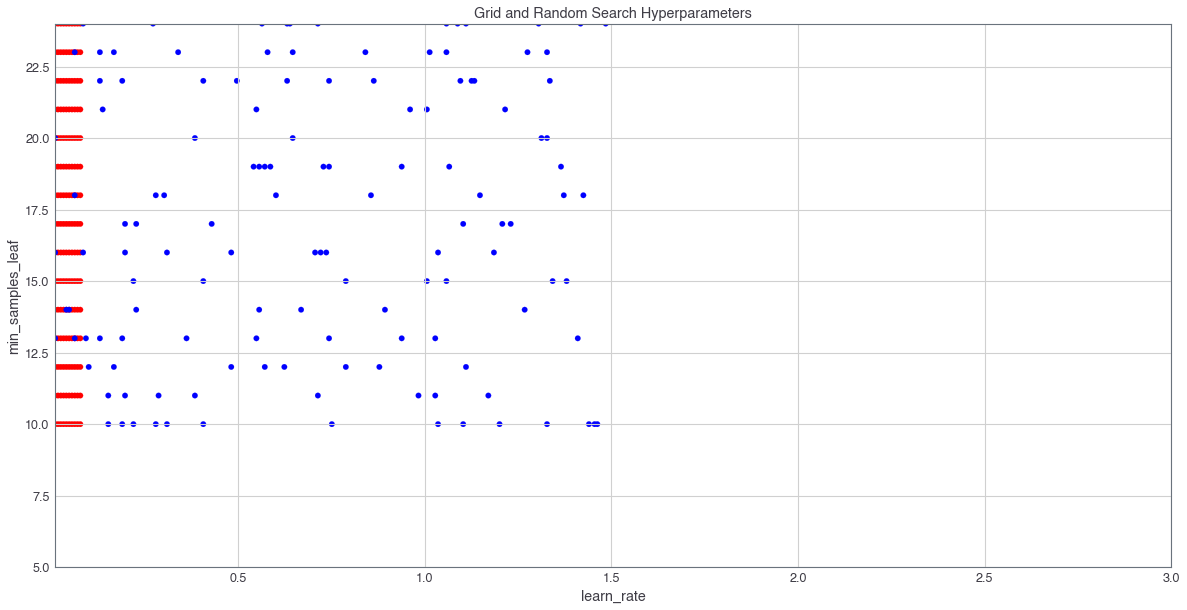

In [93]:
# Call the function to produce the visualization
visualize_search(grid_combinations_chosen, random_combinations_chosen)

We can really see how a grid search will cover a small area completely whilst random search will cover a much larger area but not completely.

# Informed Search

This final chapter gives a taste of more advanced hyperparameter tuning methodologies known as `informed search`. This includes a methodology known as Coarse To Fine as well as Bayesian & Genetic hyperparameter tuning algorithms. We will learn how informed search differs from uninformed search and gain practical skills with each of the mentioned methodologies, comparing and contrasting them as you go.

## Informed Search: Coarse to Fine

### Visualizing Coarse to Fine

We're going to undertake the first part of a Coarse to Fine search. This involves analyzing the results of an initial random search that took place over a large search space, then deciding what would be the next logical step to make your hyperparameter search finer.

In [94]:
def visualize_hyperparameter(name):
    plt.clf()
    plt.scatter(results_df[name],results_df['accuracy'], c=['blue']*500)
    plt.gca().set(xlabel='{}'.format(name), ylabel='accuracy', title='Accuracy for different {}s'.format(name))
    plt.gca().set_ylim([0,100])
    plt.show()

In [95]:
# Create the parameter grid
param_grid = {'max_depth': list(range(5,26)), 'min_samples_leaf': list(range(20, 65)), 'learning_rate': np.linspace(0.1, 2, 150)} 

In [96]:
# Create a random search object
random_GBM_class = RandomizedSearchCV(
    estimator = GradientBoostingClassifier(random_state=42),
    param_distributions = param_grid,
    n_iter = 10,
    scoring='accuracy', n_jobs=4, cv = 5, refit=True, return_train_score = True)

In [97]:
# Fit to the training data
random_GBM_class.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                     

In [98]:
# Extract and print the values used for hyperparameters
max_depth_list = random_GBM_class.cv_results_['param_max_depth']
min_samples_list = random_GBM_class.cv_results_['param_min_samples_leaf']
learn_rate_list = random_GBM_class.cv_results_['param_learning_rate']

print(max_depth_list)
print(min_samples_list)
print(learn_rate_list)

[12 5 12 10 17 17 14 20 7 18]
[54 53 21 57 62 64 61 43 21 23]
[1.3879194630872485 1.4516778523489933 1.8724832214765101
 1.1456375838926176 0.6610738255033557 0.5335570469798657
 0.2785234899328859 0.31677852348993285 0.5208053691275167
 1.5791946308724834]


In [99]:
# Combination list
combinations_list = [list(x) for x in product(max_depth_list, min_samples_list, learn_rate_list)]

In [100]:
# Confirm the size of the combinations_list
len(combinations_list)

1000

In [101]:
# Sort the results_df by accuracy and print the top 10 rows
results_df.sort_values(by='accuracy', ascending=False).head(10)

,learning_rate,accuracy
2,0.050,0.817889
1,0.010,0.817556
3,0.100,0.817000
4,0.200,0.815667
5,0.500,0.811111
0,0.001,0.778778


In [102]:
# Confirm which hyperparameters were used in this search
results_df.columns

Index(['learning_rate', 'accuracy'], dtype='object')

### Coarse to Fine Iterations

## Informed Search: Bayesian Statistics

### Bayes Rule in Python

### Bayesian Hyperparameter tuning with Hyperopt

## Informed Search: Genetic Algorithms

### Genetic Hyperparameter Tuning with TPOT

### Analyzing TPOT's stability

## Congratulations!